In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import json

In [64]:
results_dir = './results/models'

In [65]:
def template_to_regex(model_name, dataset, lp=False, model_postfix=''):
    # Escape any special regex characters in model_name
    model_prefix = re.escape(model_name)
    model_postfix = '' if model_postfix == '' else f"_{model_postfix}"
    
    # Build the pattern in parts
    pattern = f"{model_prefix}_{dataset}{model_postfix}"  # Fixed model name prefix
    if lp:
        pattern += r"_lp"          # Optional _lp
    pattern += r"_lr(\d+(?:\.\d+)?e?-?\d*)"  # Learning rate in decimal or scientific notation
    pattern += r"_wd(\d+(?:\.\d+)?e?-?\d*)"  # Weight decay in decimal or scientific notation
    pattern += r"(.*)"            # Any remaining postfix
    
    return pattern


In [66]:
model_name = "LESSVIT_b2_d6"
dataset = 'eurosat'
lp = False
pattern = template_to_regex(model_name, dataset, lp, "s2")

def get_model_name(result_dirs, model_pattern):
    filtered_model_names = []
    for result_dir in os.listdir(result_dirs):
        if re.match(model_pattern, result_dir):
            filtered_model_names.append(result_dir)
    return filtered_model_names
           
filtered_model_names = get_model_name(results_dir, pattern)

In [67]:
def get_target_logs(target_dirs):
    results = []
    for target_dir in target_dirs:
        log_path = os.path.join(results_dir, target_dir, "test_results.json")
        try:    
            with open(log_path, 'r') as f:
                log = json.load(f)
            log['model'] = target_dir
        # parse the model_dir
            log['lr'] = float(re.search(r"lr(\d+(?:\.\d+)?e?-?\d*)", target_dir).group(1))
            log['weight_decay'] = float(re.search(r"wd(\d+(?:\.\d+)?e?-?\d*)", target_dir).group(1))
            log['checkpoint'] = int(re.search(r"ckpt(\d+)", target_dir).group(1))
            results.append(log)
        except:
            continue
        # convert to df
        df = pd.DataFrame(results)
    return df

In [68]:
df_all = get_target_logs(filtered_model_names)

In [69]:
df_all


,epoch,eval_accuracy,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,model,lr,weight_decay,checkpoint
0,20.0,0.969444,0.139498,53.2176,101.470,0.808,LESSVIT_b2_d6_eurosat_s2_lr1e-4_wd0.01_ckpt50000,0.0001,0.01,50000
1,20.0,0.969630,0.125988,52.7284,102.412,0.815,LESSVIT_b2_d6_eurosat_s2_lr3e-4_wd0.01_ckpt30000,0.0003,0.01,30000
2,20.0,0.968148,0.129521,40.8790,132.097,1.052,LESSVIT_b2_d6_eurosat_s2_lr5e-4_wd0.01_ckpt50000,0.0005,0.01,50000
3,20.0,0.904815,0.282908,47.2263,114.343,0.911,LESSVIT_b2_d6_eurosat_s2_lr5e-4_wd0.01_ckpt40000,0.0005,0.01,40000
4,20.0,0.970556,0.130018,48.8926,110.446,0.879,LESSVIT_b2_d6_eurosat_s2_lr3e-4_wd0.01_ckpt600...,0.0003,0.01,60000
5,20.0,0.965741,0.154475,60.2602,89.611,0.714,LESSVIT_b2_d6_eurosat_s2_lr1e-4_wd0.01_ckpt30000,0.0001,0.01,30000
6,20.0,0.969074,0.134031,45.7618,118.002,0.940,LESSVIT_b2_d6_eurosat_s2_lr1e-4_wd0.01_ckpt40000,0.0001,0.01,40000
7,20.0,0.970741,0.117007,47.3308,114.091,0.909,LESSVIT_b2_d6_eurosat_s2_lr3e-4_wd0.01_ckpt400...,0.0003,0.01,40000
8,20.0,0.972593,0.121414,52.6597,102.545,0.817,LESSVIT_b2_d6_eurosat_s2_lr3e-4_wd0.01_ckpt60000,0.0003,0.01,60000
9,20.0,0.968148,0.140385,41.8119,129.150,1.028,LESSVIT_b2_d6_eurosat_s2_lr1e-4_wd0.01_ckpt60000,0.0001,0.01,60000


In [73]:
# sns.lineplot(data=df_all, x='lr', y='eval_accuracy', hue='checkpoint')
# set x axis log scale
# plt.xscale('log')
df_all.sort_values(by=['eval_accuracy'], ascending=False).iloc[1]['model']


'LESSVIT_b2_d6_eurosat_s2_lr3e-4_wd0.01_ckpt50000_no_moe_real'

In [8]:
df_all = pd.DataFrame()
for target_log in target_logs:
    name = '_'.join(target_log.split('_')[-3:])
    try:
        path = f'./results/logs/{target_log}/lp_metrics.csv'
        df = pd.read_csv(path)
        df.sort_values(by=[metric], inplace=True)
    except:
        continue
    # add model name
    df['model'] = name
    df_all = pd.concat([df_all, df], ignore_index=True)
# df_all.sort_values(by=[metric], inplace=True)
# get the best lr for each model
df_all_best = df_all.loc[df_all.groupby('model')[metric].idxmax()]
df_all
df_all_best.sort_values(by=[metric])

,epochs,lr,weight_decay,ce,loss,accuracy,epoch,num_samples,model
35,100,0.20,0,0.133590,0.133590,0.961317,100,4860,vit_1-2-9_d4
70,100,0.09,0,0.113127,0.113127,0.963374,100,4860,vit_1-0-11_d4


<Axes: xlabel='lr', ylabel='accuracy'>

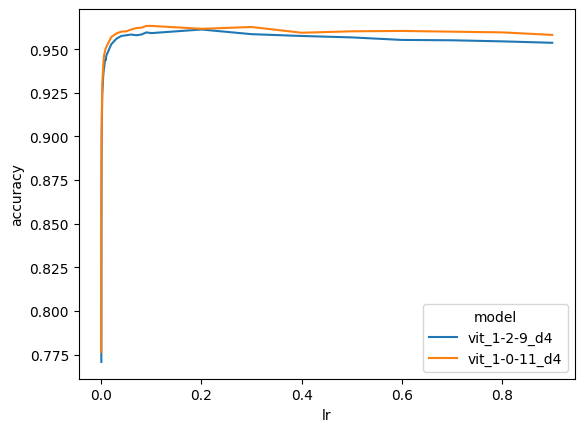

In [9]:
sns.lineplot(data=df_all.loc[df_all.epochs==100], x='lr', y=metric, hue='model')

In [40]:
# parse the model name in the df_all_best
df = df_all_best.copy()
df['model'] = df['model'].apply(lambda x: x.split('_')[-1])
df['spectral'] = df['model'].apply(lambda x: x.split('-')[0])
df['spatial_spectral'] = df['model'].apply(lambda x: x.split('-')[1])
df[metric] *= 100

IndexError: list index out of range

In [ ]:
# drop the heatmap of df_all_best_cvit, x: spatial_spectral, y: spectral, hue: metric
df_attn = df.pivot(index='spectral', columns='spatial_spectral', values=metric)
column_order = ['0', '1', '2', '4', '12']  # replace with your desired order
df_attn = df_attn.reindex(column_order, axis=1)
sns.heatmap(df_attn, annot=True, fmt=".2f", cmap='crest', linewidth=.5, vmin=60.5)
plt.title(f'{dataset} LP {metric} (%)')

KeyError: 'spatial_spectral'

In [22]:
df_all_best_cvit.pivot()

TypeError: DataFrame.pivot() takes 1 positional argument but 2 were given